# Kinetics IX

This continues discussion of enzymatic reactions, methods of analysis and linearization for experimental data, and mechanisms of enzyme inhibition.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt
import scipy.stats as stats
from math import ceil, floor

## Example 01: Urea Decomposition

Urease is a metalloenzyme (it contains Ni$^{2+}$ cations) serves an important biological function (generally in plants) of decomposing urea (U) to form ammonia (NH$_3$) and CO$_2$. It is proposed that urea decomposition occurs through a Michaelis-Menten mechanism, which we write in two steps:

\begin{align}
    U + E \rightleftharpoons EU \\
    EU \rightarrow E + P \\
\end{align}

Because it follows a Michaelis-Menten Mechanism, we know the overall rate law (See 587-L35), so the rate of reaction should have the following dependence on substrate concentration (Urea concentration).

$$r = \frac{V_\textrm{max}[U]}{K_M + [U]}$$

We are given the following data (see cell below); show that it is consistent with a Michaelis-Menten rate law, and estiamte the value of the MM parameters ($V_\textrm{max}$ and $K_M$).

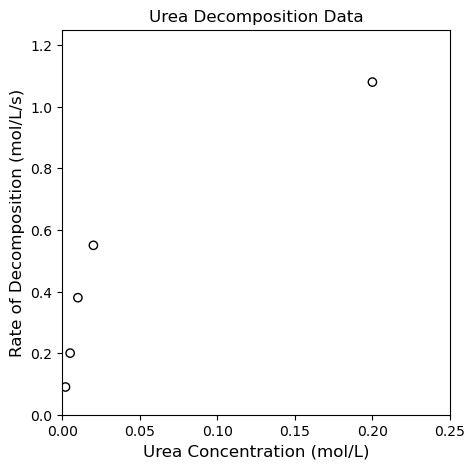

In [2]:
CU   = np.array([0.002, 0.005, 0.01, 0.02, 0.2])
rexp = np.array([0.09, 0.2, 0.38, 0.55, 1.08])

plt.figure(1, figsize = (5, 5))
plt.scatter(CU, rexp, color = 'none', edgecolor = 'black')
plt.title('Urea Decomposition Data')
plt.xlabel('Urea Concentration (mol/L)', fontsize = 12)
plt.ylabel('Rate of Decomposition (mol/L/s)', fontsize = 12)
plt.xlim(0, 0.25)
plt.ylim(0, 1.25)
plt.show()

### Solution to Example 01

Just from a simple, visual analysis, we can see that the data have a shape that could be attributed to an MM Mechanism.  At low concentrations, rate increases strongly with increasing concentration, and then at high concentrations, it seems that the rate is not responding very much to changing concentrations.  We haven't done anything rigorous yet, but this would be consistent with an MM Mechanism, where we observe first order kinetics at low substrate concentrations and zero order kinetics at high substrate concentrations.

I'd like to overlay model predictions with the measured data to see how well the rate is doing, but I need some estimates for the parameters to do that.  We can get a rough idea of the parameter values by looking at limiting behavior.  Specifically, at high substrate concentrations, we know that $K_M << [U]$, so at the limit of very high urea concentration, we should see that:

$$r = V_\textrm{max}$$

The highest concentration we've measured here is at 0.20 mol/L, where we measure a rate of 1.08 mol/L/s.  So we could gues that:

$$V_\textrm{max} \approx  1.08 \ \textrm{mol} \ \textrm{L}^{-1} \ \textrm{s}^{-1}$$

Is that concentration high enough that $K_M$ is truly $<< [U]$?  Probably not.  But this is a far better way to approach it than to blindly guess values of $V_{max}$.

Similarly, if we look at low concentration data, say rates measured at 0.002 and 0.005 mol/L, we can say in this regime that (probably) $K_M >> [U]$.  At that limit, we find:

$$r = \frac{V_\textrm{max}}{K_M}[U]$$

In other words, rate scales linearly with urea concentration, and the slope of that line should be the ratio of Vmax to KM.  We can fit a line to the two lowest concentration data points to get an estimate for $K_M$; see below

In [3]:
CUlow   = np.array([0.002, 0.005]).reshape(2,1)
rexplow = np.array([0.09, 0.2]).reshape(2,1)
X       = CUlow
Y       = rexplow
A       = np.linalg.solve(X.T@X,X.T@Y)
m       = A[0, 0]
Vmax_r  = 1.08 #mol/L/s
KM_r    = Vmax_r/m #mol/L

print(f'Rough estimates for Vmax and KM are {Vmax_r:3.3f} mol/L/s and {KM_r:3.3f} mol/L')

Rough estimates for Vmax and KM are 1.080 mol/L/s and 0.027 mol/L


That established, we can overlay the MM model with our data.  See below.

With our rough approximation, the SSE is 0.032, and the R2 is 0.948


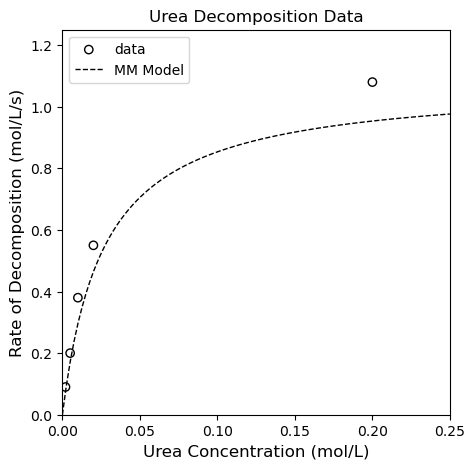

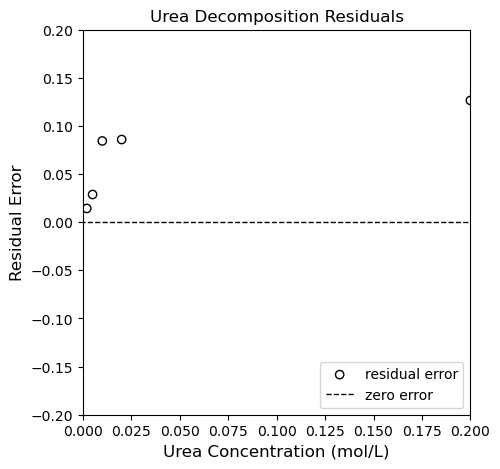

In [4]:
CUfine  = np.linspace(0, 0.25, 100)
rMM1    = Vmax_r*CUfine/(KM_r + CUfine)
resid   = rexp - Vmax_r*CU/(KM_r + CU)
SSE     = np.sum(resid**2)
SST     = np.sum((rexp - np.mean(rexp))**2)
R2      = 1 - SSE/SST

print(f'With our rough approximation, the SSE is {SSE:3.3f}, and the R2 is {R2:3.3f}')

plt.figure(1, figsize = (5, 5))
plt.scatter(CU, rexp, color = 'none', edgecolor = 'black', label = 'data')
plt.plot(CUfine, rMM1, color = 'black', linestyle = 'dashed', linewidth = 1, label = 'MM Model')
plt.title('Urea Decomposition Data')
plt.xlabel('Urea Concentration (mol/L)', fontsize = 12)
plt.ylabel('Rate of Decomposition (mol/L/s)', fontsize = 12)
plt.xlim(0, 0.25)
plt.ylim(0, 1.25)
plt.legend()
plt.show()

plt.figure(2, figsize = (5, 5))
plt.scatter(CU, resid, color = 'none', edgecolor = 'black', label = 'residual error')
plt.title('Urea Decomposition Residuals')
plt.xlabel('Urea Concentration (mol/L)', fontsize = 12)
plt.ylabel('Residual Error', fontsize = 12)
plt.xlim(0, 0.20)
plt.ylim(-0.2, 0.2)
plt.hlines(0, -0.2, 0.2, color = 'black', linestyle = 'dashed', linewidth = 1, label = 'zero error')
plt.legend(loc = 'lower right')
plt.show()

#### Nonlinear Regression

So, those rough estimates are not *bad* at all.  They generally capture the shape of the data and the order of magnitude of the rates.  Looking at the residual plots, we can see that there is a systematic underprediction of our experimental data.  We can do much beter with an optimization routine, which requires us to create an objective function.  As usual, we'll use the standard least squares approach where we minimize:

$$SSE = \sum_i (r_i - \hat{r}_i)^2$$

Below, we'll write an objective function that uses our measurements and model predictions to calculate the sum of squares as a function of the model parameters.

Using nonlinear regression, Vmax = 1.206, KM = 0.023, SSE = 0.001, and R2 = 0.999


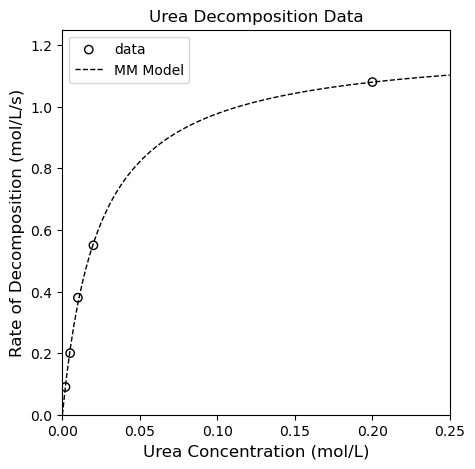

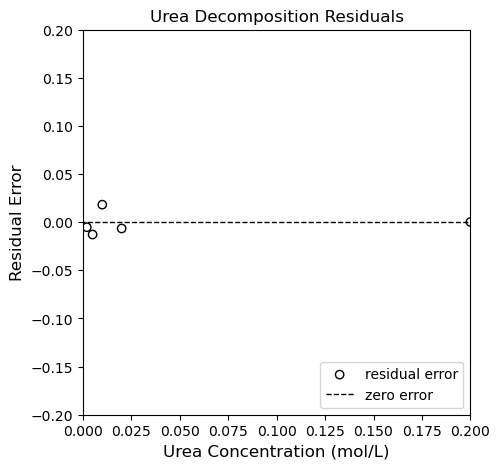

In [5]:
def obj1(par):
    Vmax, KM = par
    CU       = np.array([0.002, 0.005, 0.01, 0.02, 0.2])
    rexp     = np.array([0.09, 0.2, 0.38, 0.55, 1.08])
    rMM2     = Vmax*CU/(KM + CU)
    resid    = (rexp - rMM2)
    SSE      = np.sum(resid**2)
    return SSE

par0 = [Vmax_r, KM_r]
ans1 = opt.minimize(obj1, par0)
SSE  = ans1.fun

Vmax_opt, KM_opt = ans1.x

SST  = np.sum((rexp - np.mean(rexp))**2)
R2   = 1 - SSE/SST

rMM2    = Vmax_opt*CUfine/(KM_opt + CUfine)
resid   = rexp - Vmax_opt*CU/(KM_opt + CU)

print(f'Using nonlinear regression, Vmax = {Vmax_opt:3.3f}, KM = {KM_opt:3.3f}, SSE = {SSE:3.3f}, and R2 = {R2:3.3f}')

plt.figure(1, figsize = (5, 5))
plt.scatter(CU, rexp, color = 'none', edgecolor = 'black', label = 'data')
plt.plot(CUfine, rMM2, color = 'black', linestyle = 'dashed', linewidth = 1, label = 'MM Model')
plt.title('Urea Decomposition Data')
plt.xlabel('Urea Concentration (mol/L)', fontsize = 12)
plt.ylabel('Rate of Decomposition (mol/L/s)', fontsize = 12)
plt.xlim(0, 0.25)
plt.ylim(0, 1.25)
plt.legend()
plt.show()

plt.figure(2, figsize = (5, 5))
plt.scatter(CU, resid, color = 'none', edgecolor = 'black', label = 'residual error')
plt.title('Urea Decomposition Residuals')
plt.xlabel('Urea Concentration (mol/L)', fontsize = 12)
plt.ylabel('Residual Error', fontsize = 12)
plt.xlim(0, 0.20)
plt.ylim(-0.2, 0.2)
plt.hlines(0, -0.2, 0.2, color = 'black', linestyle = 'dashed', linewidth = 1, label = 'zero error')
plt.legend(loc = 'lower right')
plt.show()

This does a much better job of capturing the observed trends, and we see the residuals are now nicely scattered around the line of zero error, which is indicative that our model captures the data (and that deviations from zero error are attributable to random errors in the measurement).

### Linearization of MM rate expression: The Lineweaver-Burk model

It is always useful to linearize a model if we can do so.  This lets us use robust tools of linear regression (which are far more stable than iterative, numerical, nonlinear regression).  It also gives us quick, easy diagnostic tests in that we can quickly tell if our "linearized" data actually fall onto a straight line.  We use the method of Lineweaver-Burk extensively in analysis of enzyme catalyzed reactions.  It is relatively straightforward.

Starting with the MM rate expression:

$$r = \frac{V_\textrm{max}[U]}{K_M + [U]}$$

We first resist the urge to take a logarithm of both sides.  Logarithms will get you nowhere with this type of rate expression.  When you have a monomial divided by a polynomial, we can generally linearize by inverting the rate expression; in this case:

$$\frac{1}{r} = \frac{K_M + [U]}{V_\textrm{max}[U]}$$

And we can divide each term in the numerator by the monomial denominator:

$$\frac{1}{r} = \frac{K_M}{V_\textrm{max}}\frac{1}{[U]} + \frac{1}{V_\textrm{max}}$$

This is our usual $Y = mX + b$ form, so if we plot $\frac{1}{r}$ against $\frac{1}{[U]}$, we should get a straight line.  Not only that, we can estimate the MM parameters from the slope and intercept.

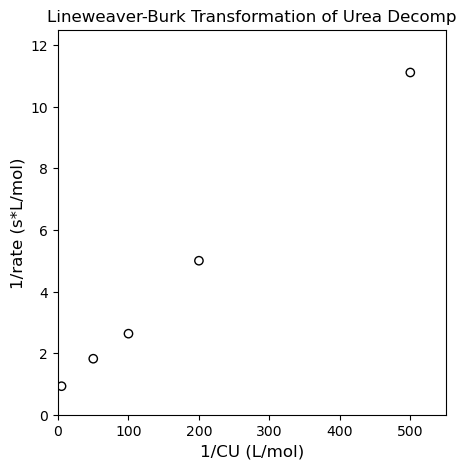

In [6]:
plt.figure(1, figsize = (5, 5))
plt.scatter(1/CU, 1/rexp, color = 'none', edgecolor = 'black')
plt.title('Lineweaver-Burk Transformation of Urea Decomp')
plt.xlabel('1/CU (L/mol)', fontsize = 12)
plt.ylabel('1/rate (s*L/mol)', fontsize = 12)
plt.xlim(0, 550)
plt.ylim(0, 12.5)
plt.show()

### Linear Regression

That looks pretty linear (as it should); let's regress the slope and intercept using linear regression.  We know that, for a linearized MM model:

$$m = \frac{K_M}{V_\textrm{max}}$$

And that:

$$b = \frac{1}{V_\textrm{max}}$$

We can easily rearrange those to solve for our parameters of interest:

$$V_\textrm{max} = \frac{1}{b}$$

and

$$K_M = V_\textrm{max}m$$

m    = 2.07e-02 +/- 1.08e-03
b    = 7.53e-01 +/- 2.65e-01
SSE  = 0.05
SST  = 67.21
MSE  = 0.01
RMSE = 0.10
R2   = 1.00
Vmax = 1.33
KM   = 0.028


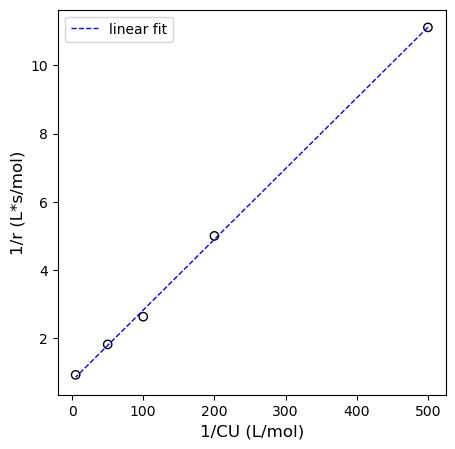

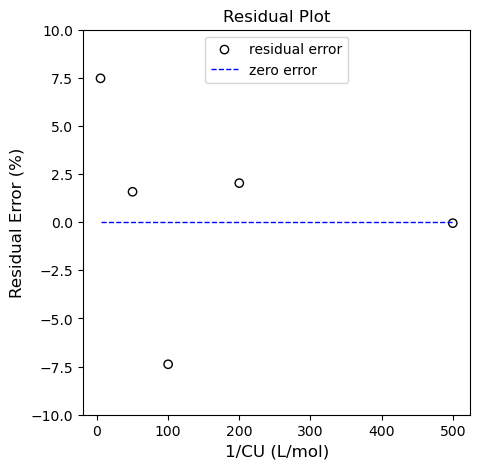

In [7]:
xdata = 1/CU
ydata = 1/rexp

X     = np.vander(xdata, 2)#This creates the X matrix shown above, truncating at 1st order
Y     = ydata    
A     = np.linalg.solve(X.T@X, X.T@Y) 
Ypred = X@A
Ybar  = np.mean(ydata)
Ndata = len(ydata)
SSE   = (Y - X@A).T@(Y - X@A) #Residual sum of squares, equivalent to SSE = np.sum((Y - Ypred)**2)
SST   = np.sum((Y - Ybar)**2) #Total sum of squares
MSE   = SSE/Ndata             #Mean Square Error
RMSE  = np.sqrt(MSE)          #Root Mean Square Error
R2    = 1 - SSE/SST           #R^2
DOF   = len(ydata) - len(A)   #Degrees of freedom = number of measurements - number of regressed parameters
s2    = SSE/DOF               #Estimate of variance, s2 ~ σ2  
COV   = s2*np.linalg.inv(X.T@X) #Covariance matrix, use for standard errors and conf. intervals
m     = A[0]                #slope of best fit line
b     = A[1]                  #y-intercept of best fit line
SEm   = np.sqrt(COV[0, 0])    #Standard error in slope
SEb   = np.sqrt(COV[1, 1])    #Standard error in y-intercept
tval  = stats.t.ppf(0.975, DOF) #t distribution value for 95% confidence intervals
CIm   = SEm*tval              #95% confidence interval on slope
CIb   = SEb*tval              #95% confidence interval on y-intercept
Vmax  = 1/b
KM    = Vmax*m

labels = ['m', 'b', 'SSE', 'SST','MSE','RMSE', 'R2', 'Vmax', 'KM']
values = [m  ,  b ,  SSE ,  SST , MSE , RMSE ,  R2 ,  Vmax ,  KM]

for label, value in zip(labels, values):
    if label == 'm':
        print(f'{label:4s} = {value:0.2e} +/- {CIm:0.2e}')
    elif label == 'b':
        print(f'{label:4s} = {value:0.2e} +/- {CIb:0.2e}')
    elif label == 'Vmax':
        print(f'{label:4s} = {value:0.2f}')
    elif label == 'KM':
        print(f'{label:4s} = {value:0.3f}')
    else:
        print(f'{label:4s} = {value:0.2f}')
     
plt.figure(1, figsize = (5, 5))
plt.scatter(X[:, 0], Y, marker = 'o', color = 'none', edgecolor = 'black')
plt.plot(X[:, 0], Ypred, color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'linear fit')
plt.xlabel('1/CU (L/mol)', fontsize = 12)
plt.ylabel('1/r (L*s/mol)', fontsize = 12)
plt.legend()
plt.show()

plt.figure(2, figsize = (5, 5))
plt.scatter(X[:, 0], (Y - Ypred)/Y*100, marker = 'o', color = 'none', edgecolor = 'black', label = 'residual error')
plt.hlines(0, floor(min(X[:, 0])), ceil(max(X[:,0])), color = 'blue', linestyle = 'dashed', linewidth = 1, label = 'zero error')
plt.xlabel('1/CU (L/mol)', fontsize = 12)
plt.ylabel('Residual Error (%)', fontsize = 12)
plt.title('Residual Plot')
plt.ylim(-10, 10)
plt.legend(loc = 'upper center')
plt.show()

## Enzyme Inhibition Mechanism 1

Like most catalysts, enzymes are sensitive to the presence of impurities, side products, or various species that can interact with the catalyst, bind to the active site or to activated complexes, and cause it to become inactive and unable to convert reactants into products.  We will consider two mechanisms of enzyme inhibition and consider how we can discern the more likely mechanism from analysis of experimental data.

We start with an enzyme catalyzed reaction as usual.  What we see at the macroscale in the lab looks like this:

**Overall**

$$E + S \longrightarrow E + P$$

But we know it is going to proceed through multiple elementary steps.  In this case, we propose that the reaction follows a standard Michaelis-Menten mechanism, but with a small twist:  the free enzyme can also bind (reversibly) with an inhibitor (I) present in the reaction media.  This enzyme inhibitor complex is inactive.  Based on that conceptual description, we can write the following reaciton mechanism -- note that it is just a slight modification to a classic MM mechanism:

**Mechanism**

\begin{align}
    E + S &\rightleftharpoons ES \\
    ES &\rightarrow E + P \\
    E + I &\rightleftharpoons EI \\
\end{align}

### Analysis

As usual with an MM mechanism, we see that the overall rate of reaction is equal to the rate of consumption of substrate (S), and it is equal to the rate of formation of the product (P).  We choose to write an overall rate expression based on the rate of product formation.

$$r = R_P$$

Now we look at the elementary steps; we can evaluate the production rate of P. It only appears as a product in step 2, so $R_P = r_2$, which means:

$$r = r_2$$

Now we expand the rate expression for step two:

$$r = k_2[ES]$$

This tells us that the rate of reaction has a first order dependence on the concentration of the enzyme-substrate complex.  We again treat the enzyme-substrate complex as a "reactive intermediate" and apply the Pseudo-steady state approximation, so we say that the net production rate of the reactive intermediate is zero:

$$R_{ES} = 0 = r_1 - r_2$$

We can then expand the rate expressions:

$$0 = k_1[S][E] - k_{-1}[ES] - k_2[ES]$$

As a reminder, I really find it helpful to try to solve for the enzyme-substrate complex (or any species bound to a catalyst) as a function of the "free catalyst sites".  This makes the algebra very easy down the road when we introduce a site balance. Solving the above PSSH equation for [ES]:

$$[ES] = \frac{k_1}{k_{-1} + k_2} [S][E]$$

Since we've already introduced the MM parameters $K_M$ and $V_\textrm{max}$, we recognize that the ratio of rate constants in the above equation is the inverse of $K_M$:

$$[ES] = \frac{1}{K_M} [S][E]$$

Now we try to resolve the concentration of free enzyme, E, using a **site balance**:

$$[E_t] = [E] + [ES] + [EI]$$

Unlike the base MM mechanism, we see that the enzyme is now distributed between 3 states, free enzyme (E), enzyme-substrate complex (ES), and the inactive enzyme-inhibitor complex (EI). Before we can solve the site balance for free enzyme concentration, [E], we need to resolve the concentration of the inhibitor complex.  We do this by writing another Pseudo-steady state approximation on EI, which appears only in step 3:

$$R_{EI} = 0 = r_3$$

Expanding the elementary rate law:

$$R_{EI} = 0 = k_3[I][E] - k_{-3}[EI]$$

We see that this expression only has the inhibitor complex as an "unknown" PSSH intermediate, so we can solve for it in terms of free enzyme concentration.

$$[EI] = \frac{k_3}{k_{-3}}[I][E]$$

For an elementary step, we recall that:

$$K_{C,i} = \frac{k_{f,i}}{k_{r,i}}$$

So we replace the rate constant ratio with a concentration-based equilibrium constant, $K_C$:

$$[EI] = K_{3_C}[I][E]$$

Here we have expressed [EI] as a function of free enzyme as we've done previously with [ES].  Now we can substitute both of these expressions into the site balance:

$$[E_t] = [E] + \frac{1}{K_M} [S][E] + K_{3_C}[I][E] $$

Now, we can see that we only have a single "unknown" here, which is the free enzyme concentration. Even better, we've approached the solution in such a way that every term in the polynomial on the right hand side has a linear dependence on [E], so it is really straightforward to solve for [E]:

$$[E] = \frac{[E_t]}{1 + \frac{1}{K_M}[S] + K_{3_C}[I]}$$

Now we've expressed all of the PSSH intermediates and the free enzyme concentration in terms of measurable or known quantities, so we start building up our rate expression by substituting them back into the starting point:

The overall rate of reaction is equal to the rate of the step where the product is formed:

$$r = k_2[ES]$$

Next:

$$r = \frac{k_2}{K_M} [E][S]$$

Finally substituting in the free enzyme concentration:

$$r = \frac{k_2[E_t][S]}{K_M\left(1 + \frac{1}{K_M}[S] + K_{3_C}[I]\right)}$$

Distributing the $K_M$ term in the denominator gives:

$$r = \frac{k_2[E_t][S]}{K_M + [S] + K_MK_{3_C}[I]}$$

And we group the terms multipled by $K_M$ to get:

$$r = \frac{k_2[E_t][S]}{[S] + K_M(1 + K_{3_C}[I])}$$

Noticing the product of $k_2[E_t]$ in the numerator, we recall that this is equal to $V_\textrm{max}$, which gives the final rate expression for this mechanism:

$$r = \frac{V_\textrm{max}[S]}{[S] + K_M(1 + K_{3_C}[I])}$$

It is worth comparing this result with the classic MM mechanism:

$$r = \frac{V_\textrm{max}[S]}{[S] + K_M}$$

We can see that the more complex mechanism approaches the MM Mechanism in the limit where the inhibitor concentration is zero.  This is a great consistency check!!

## Enzyme Inhibition Mechanism 2

Now we will consider a second mechanism of enzyme inhibition.  Here, we propose that the overall reaction is the same as above:

**Overall**

$$E + S \longrightarrow E + P$$

We again propose a conventional MM Mechanism, but here we also say that there is an inhibitor present, and that it binds (reversibly) with the enzyme substrate complex, converting it to an inactive form that cannot transform the substrate into products:

**Mechanism**

\begin{align}
    E + S &\rightleftharpoons ES \\
    ES &\rightarrow E + P \\
    ES + I &\rightleftharpoons IES \\
\end{align}

### Analysis

The overall rate of reaction is equal to the rate of formation of the product (P), so we write the overall rate expression based on the rate of product formation:

$$r = R_P$$

P only appears as a product in step 2, so $R_P = r_2$, which means:

$$r = r_2$$

Expanding the rate expression for step two:

$$r = k_2[ES]$$

We treat the enzyme-substrate complex as a "reactive intermediate" and apply the Pseudo-steady state approximation as usual.  Here we note a change from the base MM case in that the enzyme substrate complex is consumed as a reactant in step 3:

$$R_{ES} = 0 = r_1 - r_2 - r_3$$

Expanding the rate expressions:

$$0 = k_1[S][E] - k_{-1}[ES] - k_2[ES] - (k_3[I][ES] - k_{-3}[IES])$$

Pausing here, I remind myself that I'd like to solve for the concentration of the enzyme substrate complex as a function of free enzyme.  I can't do that yet -- I see the concentration of the inhibitor-enzyme-substrate complex appears in this PSSH equation.  I need to express that in terms of stable species and rate constants, so I write another PSSH on IES:

$$R_{IES} = 0 = r_3$$

Expanding that elementary rate expression:

$$R_{IES} = 0 = k_3[I][ES] - k_{-3}[IES]$$

Now we have basically two equations (PSSH on ES and on IES) and two unknowns ([ES] and [IES]).  We cn solve the system. It is worth strategizing a bit about how to approach the solution.  Right off the bat, I notice that the PSSH on IES requires that r3 = 0.  That lets me simplify the PSSH on ES (see above) from $0 = r_1 - r_2 - r_3$ to:

$$R_{ES} = 0 = r_1 - r_2$$

Which expands to:

$$0 = k_1[S][E] - k_{-1}[ES] - k_2[ES]$$

This is identical to what we solved for the classic MM and the first enzyme inhibition case.  We can solve directly for [ES] as a function of free enzyme concentration, which is always what I try to do with species bound to the catalyst.

$$[ES] = \frac{k_1}{k_{-1} + k_2} [S][E]$$

We'll replace that ratio of rate constants with $K_M$ straightaway:

$$[ES] = \frac{1}{K_M} [S][E]$$

With that established, we can now work on the [IES] concentration.  Starting with the PSSH expression:

$$0 = k_3[I][ES] - k_{-3}[IES]$$

We find that:

$$[IES] = \frac{k_3}{k_{-3}}[I][ES]$$

And remembering that our rate constant ratio is equal to a $K_C$:

$$[IES] = K_{3_C}[I][ES]$$

We already solved for [ES] so we make the substitution:

$$[IES] = \frac{K_{3_C}}{K_M}[I][S][E]$$

Now we have both [ES] and [IES] expressed as functions of free enzyme concentration [E], which makes it easy to solve for [E] from the site balance:

$$[E_t] = [E] + [ES] + [IES]$$

Making substitutions:

$$[E_t] = [E] + \frac{1}{K_M} [S][E] + \frac{K_{3_C}}{K_M}[I][S][E]$$

We now have every term on the right hand side of our site balance expressed as a linear function of free enzyme concentation [E], which makes for an easy solution:

$$[E] = \frac{[E_t]}{1 + \frac{1}{K_M}[S] + \frac{K_{3_C}}{K_M}[I][S]}$$

Now we just substitute everything back into the original expression for the overall reaction rate:

$$r = k_2[ES]$$

Next:

$$r = \frac{k_2}{K_M} [E][S]$$

Finally substituting in the free enzyme concentration:

$$r = \frac{k_2[E_t][S]}{K_M\left(1 + \frac{1}{K_M}[S] + \frac{K_{3_C}}{K_M}[I][S]\right)}$$

Distributing the $K_M$ term in the denominator gives:

$$r = \frac{k_2[E_t][S]}{K_M + [S] + K_{3_C}[I][S]}$$

Grouping the terms multipled by [S] in the denominator:

$$r = \frac{k_2[E_t][S]}{K_M + [S](1 + K_{3_C}[I])}$$

Finally, replacing $k_2[E_t]$ in the numerator with $V_\textrm{max}$, we get the final rate expression for this mechanism:

$$r = \frac{V_\textrm{max}[S]}{K_M + [S](1 + K_{3_C}[I])}$$

It is worth comparing this result with the classic MM mechanism:

$$r = \frac{V_\textrm{max}[S]}{K_M + [S]}$$

And again we see that the more complex mechanism approaches the MM Mechanism in the limit where the inhibitor concentration is zero.  If this were not the case, we should suspect that we did something wrong in our analysis.

## Distinguishing Between Mechanisms of Inhibition by linearization

### Michaelis-Menten

When we looked at the baseline MM Mechanism:

$$r = \frac{V_\textrm{max}[S]}{K_M + [S]}$$

We found that a useful linearization is the method of Lineweaver-Burk; we invert the rate expression, which gives us a linearized form:

$$\frac{1}{r} = \frac{K_M + [S]}{V_\textrm{max}[S]}$$

Dividing each term in the numerator polynomial by the denominator:

$$\frac{1}{r} = \frac{K_M}{V_\textrm{max}}\frac{1}{[S]} + \frac{1}{V_\textrm{max}}$$

That is the equation for a straight line if we let $Y = 1/r$ and $X = 1/[S]$.  We can get estimates for $K_M$ and $V_\textrm{max}$ from the regressed slope and intercept.

Now we look at our two inhibition mechanims and work through the same linearization strategy:

### Inhibition Mechanism 1: $I + E \rightleftharpoons EI$

$$r = \frac{V_\textrm{max}[S]}{[S] + K_M(1 + K_{3_C}[I])}$$

Inverting the expression:

$$\frac{1}{r} = \frac{[S] + K_M(1 + K_{3_C}[I])}{V_\textrm{max}[S]}$$

And distributing the denominator:

$$\frac{1}{r} = \frac{1}{V_\textrm{max}} + \frac{K_M(1 + K_{3_C}[I])}{V_\textrm{max}}\frac{1}{[S]}$$

Rearranging to Y = mX + b form just to compare with baseline expression directly:

$$\frac{1}{r} = \frac{K_M(1 + K_{3_C}[I])}{V_\textrm{max}}\frac{1}{[S]} + \frac{1}{V_\textrm{max}}$$

### Inhibition Mechanism 2: $I + ES \rightleftharpoons IES$

$$r = \frac{V_\textrm{max}[S]}{K_M + [S](1 + K_{3_C}[I])}$$

Inverting the expression:

$$\frac{1}{r} = \frac{K_M + [S](1 + K_{3_C}[I])}{V_\textrm{max}[S]}$$

And distributing the denominator:

$$\frac{1}{r} = \frac{K_M}{V_\textrm{max}}\frac{1}{[S]} + \frac{(1 + K_{3_C}[I])}{V_\textrm{max}}$$

This one is already in Y = mX + b form.

### Comparing Linearized Expressions

\begin{align}
    \frac{1}{r} &= \frac{K_M}{V_\textrm{max}}\frac{1}{[S]} + \frac{1}{V_\textrm{max}} \\
    \\
    \frac{1}{r} &= \frac{K_M(1 + K_{3_C}[I])}{V_\textrm{max}}\frac{1}{[S]} + \frac{1}{V_\textrm{max}} \\
    \\
    \frac{1}{r} &= \frac{K_M}{V_\textrm{max}}\frac{1}{[S]} + \frac{(1 + K_{3_C}[I])}{V_\textrm{max}} \\
\end{align}


We can see that the impacts of inhibitor concentration will show up in the slopes and intercepts of the linearized data sets.  To resolve the dependencies, we would have to measure reaction rates at various concentrations of substrate **for various concentrations of the inhibitor**.  Then, we would look at linearized data sets to see how the slope and intercept respond.

Let's look at the Case 1 linearization first:

$$\frac{1}{r} = \frac{K_M(1 + K_{3_C}[I])}{V_\textrm{max}}\frac{1}{[S]} + \frac{1}{V_\textrm{max}}$$

Here, we see that changing inhibitor concentration has no impact on the y-intercept.  It will always be equal to 1/Vmax, no matter the inhibitor concentration.  The slope will change with inhibitor concentration, though.  It becomes larger (steeper) for higher inhibitor concentrations and smaller (shallower) for lower inhibitor concentrations.  This is illustrated in the graph below.

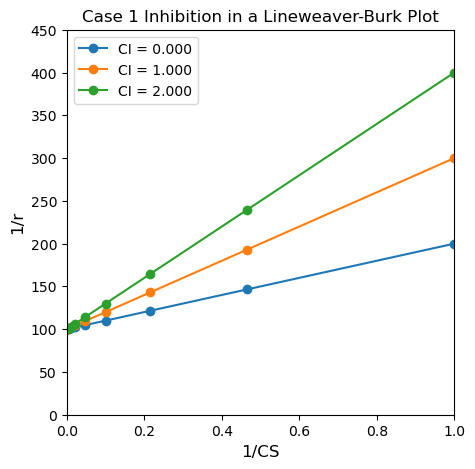

In [8]:
K3 = 1
KM = 1
Vmax = 0.01

r = lambda CS, CI: Vmax*CS/(CS + KM*(1 + K3*CI))

CS_exp = np.logspace(0, 3, 10)
CI_exp = np.array([0.0, 1, 2.0])

plt.figure(1, figsize = (5, 5))
for i, value in enumerate(CI_exp):
    plt.plot(1/CS_exp, 1/r(CS_exp, value), marker = 'o', label = f'CI = {CI_exp[i]:3.3f}')
plt.title('Case 1 Inhibition in a Lineweaver-Burk Plot')
plt.xlabel('1/CS', fontsize = 12)
plt.ylabel('1/r', fontsize = 12)
plt.ylim(0, 450)
plt.xlim(0, 1)
plt.legend()
plt.show()

So we can see clearly that if we have Case 1 type inhibition ($I + E \rightleftharpoons EI$), we should be able to detect it from ***varying slopes*** in a Lineweaver-Burk plot when we obtain data at various inhibitor concentrations.

If instead we have Case 2 inhibition ($I + ES \rightleftharpoons IES$):

$$\frac{1}{r} = \frac{K_M}{V_\textrm{max}}\frac{1}{[S]} + \frac{(1 + K_{3_C}[I])}{V_\textrm{max}}$$

We should see the impact of changing inhibitor concentration in the y-intercept, whereas the slope in a Lineweaver-Burk plot will remain constant.  This behavior is illustrated below.

$$r = \frac{V_\textrm{max}[S]}{K_M + [S](1 + K_{3_C}[I])}$$

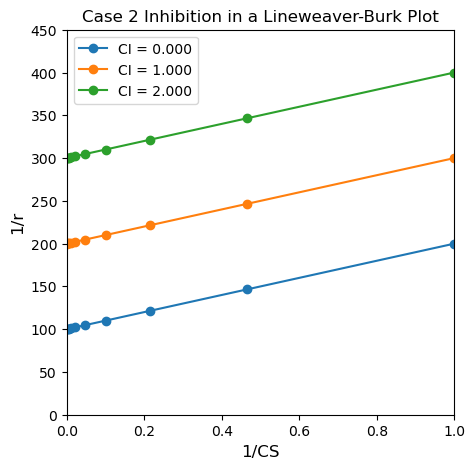

In [9]:
K3 = 1
KM = 1
Vmax = 0.01

r = lambda CS, CI: Vmax*CS/(KM + CS*(1 + K3*CI))

CS_exp = np.logspace(0, 3, 10)
CI_exp = np.array([0.0, 1, 2.0])

plt.figure(1, figsize = (5, 5))
for i, value in enumerate(CI_exp):
    plt.plot(1/CS_exp, 1/r(CS_exp, value), marker = 'o', label = f'CI = {CI_exp[i]:3.3f}')
plt.title('Case 2 Inhibition in a Lineweaver-Burk Plot')
plt.xlabel('1/CS', fontsize = 12)
plt.ylabel('1/r', fontsize = 12)
plt.ylim(0, 450)
plt.xlim(0, 1)
plt.legend()
plt.show()